In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
import pylab

plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

%matplotlib inline

In [2]:
df = pd.read_csv("./twitter_combined.txt.gz", compression='infer', sep=" ", header=None, names=["a", "b"])
print(len(df))
df.head()

2420766


,a,b
0,214328887,34428380
1,17116707,28465635
2,380580781,18996905
3,221036078,153460275
4,107830991,17868918


In [3]:
nodes = list(set(df["a"]) | set(df["b"]))
nodes.sort()
nodes[:20]
nodes_to_idx = {n:i for i,n in enumerate(nodes)}

df_o = df
df = pd.DataFrame({"a": df["a"].apply(lambda x: nodes_to_idx[x]), 
                   "b": df["b"].apply(lambda x: nodes_to_idx[x])})
df.head()   

,a,b
0,64848,33444
1,15266,30189
2,76829,19302
3,65515,58679
4,52420,16766


In [4]:
e = len(df)
v = len(np.unique(df.a))
v = max(np.max(np.unique(df.a)), np.max(np.unique(df.b))) + 1
print(e,v)

2420766 81306


In [5]:
facebook2 = csr_matrix((np.ones(e), (df.a, df.b)), shape=(v,v))
facebook2 = 1 * ((facebook2 + facebook2.T) !=0)

In [6]:
import networkx as nx
import metis

In [7]:
%time g = nx.from_scipy_sparse_matrix(facebook2)

CPU times: user 32.8 s, sys: 236 ms, total: 33 s
Wall time: 33.1 s


# Ancienne méthode

n_clusters = int(facebook2.shape[0]/100)
print(n_clusters)

%time (edgecuts, parts) = metis.part_graph(g, n_clusters, objtype='cut', ufactor=1000, contig=True, niter=100)
print(edgecuts, len(parts), len(np.unique(parts)))
parts = np.array(parts)

# Nouvelle méthode

In [8]:
n_clusters = int(facebook2.shape[0]/40)
print(n_clusters)

%time adj = metis.adjlist_to_metis(list(df.to_records(index=None)))

%time (edgecuts, parts) = metis.part_graph(g, n_clusters, objtype='cut', ufactor=1000, contig=True, niter=100)
print(edgecuts, len(parts), len(np.unique(parts)))
parts = np.array(parts)

2032
CPU times: user 32 s, sys: 88 ms, total: 32.1 s
Wall time: 32.1 s
CPU times: user 24.4 s, sys: 140 ms, total: 24.6 s
Wall time: 24.6 s
853210 81306 2007


In [9]:
nodes = pd.DataFrame({"part": parts})
nodes.groupby("part").size().describe()

count    2007.000000
mean       40.511211
std        24.728551
min         1.000000
25%        20.000000
50%        27.000000
75%        67.000000
max        87.000000
dtype: float64

Cluster #6 is of size 80
pseudo-degree of cluster is 127


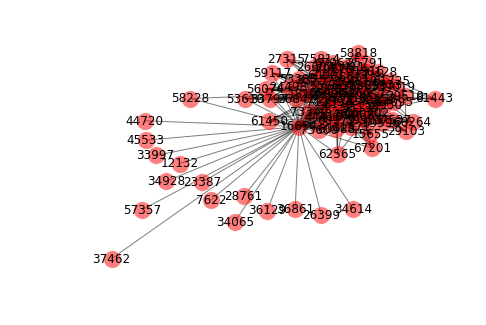

In [10]:
from IPython.html.widgets import interact
import graph_helpers
from imp import reload
reload(graph_helpers)

@interact
def plot(cl = ('6', '7', '8', '10', '20', '30'), degree=("0", "1", "2"), layout=("spring", "std", "spectral")):
    cl = int(cl)
    print("Cluster #%d is of size %d" % (cl, (parts == cl).sum()))
    
    print("pseudo-degree of cluster is %d" % graph_helpers.get_deg_sub(facebook2, parts == cl))
    
    graph_helpers.plot_subgraph_links(facebook2, parts == cl, int(degree), layout=layout, graph=g)

count    2032.000000
mean      350.198327
std       401.857495
min         0.000000
25%       114.750000
50%       224.000000
75%       442.000000
max      4091.000000
dtype: float64


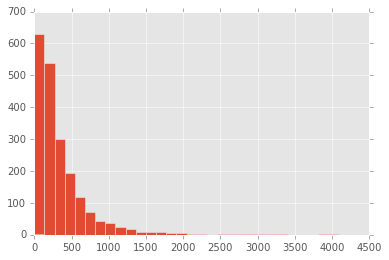

In [11]:
all_degs = [graph_helpers.get_deg_sub(facebook2, parts == i) for i in range(n_clusters)]
print(pd.Series(all_degs).describe())
_ = plt.hist(all_degs, bins=30)

In [12]:
cl6 = np.where(parts == 6)[0]
df[(df.a.isin(cl6)) & ~ (df.b.isin(cl6))]

,a,b
383966,16654,8222
760676,32404,32540
760682,35260,35772
760684,22408,18913
760708,27571,33054
760710,27571,67098
760711,32153,29745
760718,29333,29745
760719,22408,3565
760723,26609,67098


In [13]:
df[(df.b.isin(cl6)) & ~ (df.a.isin(cl6))]

,a,b
384030,8222,16654
384169,31217,16654
760683,17233,40411
760690,58053,61725
760734,17233,59905
760754,17233,5069
760758,17233,36128
760763,67098,59905
760803,9952,5069
760848,67098,53110


In [14]:
clusters = parts

### Evaluation de performance

In [26]:
from gmet import group_vertex_degree, group_edge_degree

%time cldegs_pd = pd.DataFrame({'sz': [(clusters == cl).sum() for cl in range(n_clusters)], \
                          'vdeg': [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)], \
                          'edeg': [group_edge_degree(facebook2, clusters == i) for i in range(n_clusters)]})

cldegs_pd["vratio"] = cldegs_pd.vdeg / cldegs_pd.sz
cldegs_pd["eratio"] = cldegs_pd.edeg / cldegs_pd.sz

cldegs_pd.describe()

CPU times: user 3min 27s, sys: 28 ms, total: 3min 27s
Wall time: 3min 27s


,edeg,sz,vdeg,vratio,eratio
count,2032.000000,2032.000000,2032.000000,2007.000000,2007.000000
mean,839.764764,40.012795,350.198327,10.107981,20.039549
std,1169.690131,24.978530,401.857495,10.002445,16.886219
min,0.000000,0.000000,0.000000,0.086957,0.147059
25%,245.000000,20.000000,114.750000,3.123106,7.790909
50%,454.500000,27.000000,224.000000,6.950000,15.850000
75%,921.250000,66.000000,442.000000,13.869318,27.097619
max,13402.000000,87.000000,4091.000000,94.117647,167.525000


In [27]:
cldegs_pd[cldegs_pd.vratio < 0.5].describe()

,edeg,sz,vdeg,vratio,eratio
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,29.200000,26.833333,8.533333,0.292451,1.004704
std,41.556277,23.212784,9.265186,0.101188,0.531222
min,3.000000,3.000000,1.000000,0.086957,0.147059
25%,4.000000,4.000000,1.000000,0.250000,0.578843
50%,12.500000,24.000000,5.500000,0.318841,1.000000
75%,29.250000,42.000000,13.000000,0.351041,1.105072
max,173.000000,80.000000,34.000000,0.452381,2.261905


In [28]:
cldegs_pd[cldegs_pd.vratio < 0.5][cldegs_pd.vdeg < 10].describe()

/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,edeg,sz,vdeg,vratio,eratio
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,9.750000,13.800000,3.150000,0.259164,0.893484
std,9.101041,12.837445,3.116594,0.098475,0.331448
min,3.000000,3.000000,1.000000,0.086957,0.147059
25%,3.750000,3.750000,1.000000,0.191667,0.891304
50%,5.000000,6.000000,1.000000,0.254032,1.000000
75%,12.250000,23.500000,4.750000,0.333333,1.000000
max,31.000000,42.000000,9.000000,0.450000,1.550000


In [29]:
df = cldegs_pd

df[df.eratio < 2].describe()

,edeg,sz,vdeg,vratio,eratio
count,89.000000,89.000000,89.000000,89.000000,89.000000
mean,40.865169,31.528090,22.449438,0.631867,1.175070
std,44.358609,28.496048,26.470829,0.345482,0.409998
min,1.000000,1.000000,1.000000,0.086957,0.147059
25%,3.000000,3.000000,1.000000,0.352113,1.000000
50%,26.000000,27.000000,10.000000,0.526316,1.000000
75%,71.000000,52.000000,40.000000,0.887500,1.529412
max,157.000000,80.000000,131.000000,1.637500,1.962500


0.012130905511811025


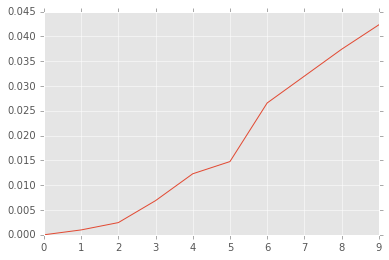

In [30]:
def vratios(df):
    return [len(df[df.vratio < i/10.])/len(df) for i in range(10)]

def perf(df):
    er = vratios(df)
    return sum([i * er[i] / 10. for i in range(10)]) / 10.

er = vratios(cldegs_pd)

print (perf(cldegs_pd))

plt.plot(er)